In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
from mpl_toolkits.basemap import Basemap, shiftgrid

# Drake Passage Transport
First let's look at a timeseries of Drake Passage transport from each of our comparison runs. For this we will use tx_trans, summed across Drake Passage latatides (x=2100, y = 225:650).


[]
[]
[]
['output150', 'output151', 'output152', 'output153', 'output154', 'output155', 'output156', 'output157', 'output158', 'output159', 'output160', 'output161', 'output162', 'output163', 'output164', 'output165', 'output166', 'output167', 'output168', 'output169']


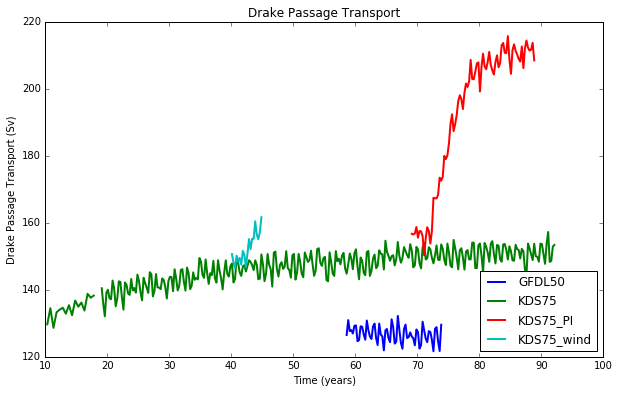

In [18]:
DataDir = './'
expts = ['GFDL50','KDS75','KDS75_PI','KDS75_wind']
plt.figure(figsize=(10,6))

for e in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir,e)
    FileList = [f for f in os.listdir(ExpDir) if f.startswith('output')]
    FileList.sort()
    
    # Is there any processed data to load?
    MetricsFile = os.path.join(ExpDir,'SimulationMetrics.npz')
    if os.path.exists(MetricsFile):
        data = np.load(MetricsFile)
        Time = data['Time']
        DrakePassageTransport = data['DrakePassageTransport']
        ProcessedFiles = data['FileList']
        FilesToProcess = [x for x in FileList if x not in ProcessedFiles]
    else:
        Time = []
        DrakePassageTransport = []
        # Make this so it actually decides which files have been processed.
        FilesToProcess = FileList
        
    print FilesToProcess
    # If there are unprocessed files, load their data from them
    for g in FilesToProcess:
        OceanFile = os.path.join(ExpDir,g,'ocean.nc')
        if os.path.exists(OceanFile):
            ncFile = Dataset(OceanFile)
            Time = np.append(Time,ncFile.variables['time'][:]/365.) 
            tx_trans = ncFile.variables['tx_trans'][0,:,225:650,2100]
            ncFile.close()
            DrakePassageTransport = np.append(DrakePassageTransport,np.ma.sum(tx_trans))
    
    plt.plot(Time,DrakePassageTransport,label=e,linewidth=2)
    
    # Save processed data to npz file
    np.savez(MetricsFile, Time = Time, DrakePassageTransport = DrakePassageTransport, FileList=FileList)

    
plt.legend(loc=4)
plt.ylabel('Drake Passage Transport (Sv)')
plt.xlabel('Time (years)')
plt.title('Drake Passage Transport')
plt.savefig('figures/DPTrans.pdf')

# Scalar Quantities
Look at some quantities that are saved in ocean_scalar.nc.

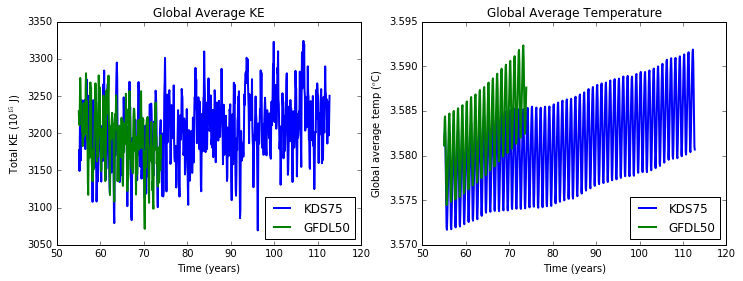

In [6]:
plt.figure(figsize=(12,4))

expt = 'KDS75'
expdir = os.path.join(datadir,expt)

time=[];
ke_tot = [];
temp_global_ave = [];

outList = [f for f in os.listdir(expdir) if f.startswith('output')]
outList.sort()

ii=0
for g in outList:
    ii+=1
    oceanfile = os.path.join(expdir,g,'ocean_scalar.nc')
    ncFile = Dataset(oceanfile) 
    time = np.append(time,ncFile.variables['time'][:]/365. + 45.) 
    ke_tot = np.append(ke_tot,ncFile.variables['ke_tot'][:]) 
    temp_global_ave = np.append(temp_global_ave,ncFile.variables['temp_global_ave'][:]) 
    ncFile.close()


plt.subplot(121)
plt.plot(time,ke_tot,label=expt,linewidth=2)

plt.subplot(122)
plt.plot(time,temp_global_ave,label=expt,linewidth=2)

expt = 'GFDL50'
expdir = os.path.join(datadir,expt)

time=[];
ke_tot = [];
temp_global_ave = [];

outList = [f for f in os.listdir(expdir) if f.startswith('output')]
outList.sort()

ii=0
for g in outList:
    ii+=1
    oceanfile = os.path.join(expdir,g,'ocean_scalar.nc')
    ncFile = Dataset(oceanfile) 
    time = np.append(time,ncFile.variables['time'][:]/365.) 
    ke_tot = np.append(ke_tot,ncFile.variables['ke_tot'][:]) 
    temp_global_ave = np.append(temp_global_ave,ncFile.variables['temp_global_ave'][:]) 
    ncFile.close()

plt.subplot(121)
plt.plot(time,ke_tot,label=expt,linewidth=2)


plt.subplot(122)
plt.plot(time,temp_global_ave,label=expt,linewidth=2)

plt.subplot(121)
plt.legend(loc=4)
plt.ylabel('Total KE (10$^{15}$ J)')
plt.xlabel('Time (years)')
plt.title('Global Average KE')

plt.subplot(122)
plt.legend(loc=4)
plt.ylabel('Global average temp ($^o$C)')
plt.xlabel('Time (years)')
plt.title('Global Average Temperature')

plt.savefig('figures/Scalars.pdf')

# Overturning Circulation
Next, let's look at overturning circulation in density space using ty_trans_rho. We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

Final file was  /g/data/v45/mom01_comparison/KDS75/output260/ocean.nc
Final file was  /g/data/v45/mom01_comparison/GFDL50/output403/ocean.nc


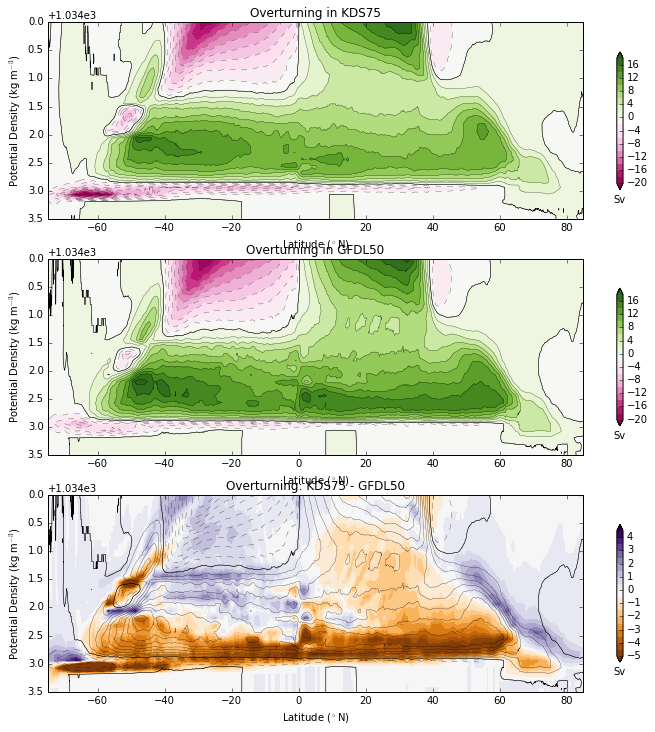

In [7]:
plt.figure(figsize=(12,12))

expt = 'KDS75'
expdir = os.path.join(datadir,expt)

outList = [f for f in os.listdir(expdir) if f.startswith('output')]
outList.sort()

ii=0
for g in outList[-24:]: 
    ii+=1
    oceanfile = os.path.join(expdir,g,'ocean.nc')
    #print oceanfile
    ncFile = Dataset(oceanfile) 
    potrho = ncFile.variables['potrho'][:]
    yu = ncFile.variables['grid_yu_ocean'][:]
    ty_trans_rho = ncFile.variables['ty_trans_rho'][0,:,:,:]
    ncFile.close()

    if ii==1:
        psi = np.ma.sum(np.ma.cumsum(ty_trans_rho,axis=0),axis=2)
    else:
        psi = psi + np.ma.sum(np.ma.cumsum(ty_trans_rho,axis=0),axis=2)
        
psi_KDS = psi/ii

#print psi_KDS

#x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
clev = np.arange(-20,20,2)

print "Final file was ", oceanfile

plt.subplot(311)
plt.contourf(yu,potrho,psi_KDS,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu,potrho,psi_KDS,levels=clev,colors='k',linewidths=0.25)
plt.contour(yu,potrho,psi_KDS,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Overturning in KDS75')


expt = 'GFDL50'
expdir = os.path.join(datadir,expt)

outList = [f for f in os.listdir(expdir) if f.startswith('output')]
outList.sort()

ii=0
for g in outList[-20:]:
    ii+=1
    oceanfile = os.path.join(expdir,g,'ocean.nc')
    #print oceanfile
    ncFile = Dataset(oceanfile) 
    potrho = ncFile.variables['potrho'][:]
    yu = ncFile.variables['grid_yu_ocean'][:]
    ty_trans_rho = ncFile.variables['ty_trans_rho'][0,:,:,:]
    ncFile.close()

    if ii==1:
        psi = np.ma.sum(np.ma.cumsum(ty_trans_rho,axis=0),axis=2)
    else:
        psi = psi + np.ma.sum(np.ma.cumsum(ty_trans_rho,axis=0),axis=2)
        
psi_GFDL = psi/ii

print "Final file was ", oceanfile

#x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
clev = np.arange(-20,20,2)

plt.subplot(312)
plt.contourf(yu,potrho,psi_GFDL,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu,potrho,psi_GFDL,levels=clev,colors='k',linewidths=0.25)
plt.contour(yu,potrho,psi_GFDL,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Overturning in GFDL50')

psi_diff = psi_KDS - psi_GFDL
dlev = np.arange(-5,5,0.5)

plt.subplot(313)
plt.contourf(yu,potrho,psi_diff,cmap=plt.cm.PuOr,levels=dlev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu,potrho,psi_GFDL,levels=clev,colors='k',linewidths=0.25)
plt.contour(yu,potrho,psi_GFDL,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Overturning: KDS75 - GFDL50')

plt.savefig('figures/Overturning.pdf')

In [5]:
print 'For densities exceeding: ', potrho[68]
print 'And at latitude:', yu[500]
print np.min(psi_GFDL[68:,500])
print np.min(psi_KDS[68:,500])

For densities exceeding:  1036.5625
And at latitude: -59.467702335
-5.85332
-21.7023


In [29]:

print np.min(psi_GFDL[68:,500])

-5.85332


# Summary
* we discovered this
